# ML: Homework 2
## Alisher Tortay 20140904

# 1. Support Vector Machines


In [269]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.datasets import load_svmlight_file
%pylab inline
import matplotlib.pyplot as plt
import cvxopt
from scipy.stats import multivariate_normal as mvn
from numpy.core.umath_tests import matrix_multiply as mm

Populating the interactive namespace from numpy and matplotlib


In [3]:
x_data, y_data = load_svmlight_file("a1a.txt")
y = y_data 
x = x_data.todense()

Function that creates linear kernel

In [58]:
def lin_gram(x):
    return np.dot(x, np.transpose(x))

This function solves dual problem using cvxopt. Then it determines support vectors. I used threshold of 1e-4. After that it computes bias. At first I tried to compute bias using only one support vector with alpha < C. However it requires additional thresholding near C. So I decided to use average of these values.

In [230]:
def solve_lin(x, y, C):
    m, n = x.shape
    K = lin_gram(x)
    P = cvxopt.matrix(np.multiply(K, np.outer(y,y)))
    q = cvxopt.matrix(np.ones(m) * -1)
    
    A = cvxopt.matrix(y, (1,m))
    b = cvxopt.matrix(0.0)
    
    G1 = np.diag(np.ones(m)*-1)
    G2 = np.diag(np.ones(m))
    G = cvxopt.matrix(np.vstack((G1, G2)))
    h1 = np.zeros(m)
    h2 = np.ones(m)*C
    h = cvxopt.matrix(np.hstack((h1, h2)))
    
    cvxopt.solvers.options['show_progress'] = False
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(solution['x'])
    
    # Support vectors
    sv = alpha > 1e-4
    ind = np.arange(len(alpha))[sv]
    alpha = alpha[sv]
    sv_x = x[sv]
    sv_y = y[sv]

    # Bias
    bias = 0
    for i in range(len(alpha)):
        bias += sv_y[i]
        bias -= np.sum(alpha * sv_y * K[ind[i], sv].transpose())
    bias /= len(alpha)
    
    return (sv_x, sv_y, alpha, bias) 

This is simple function that predicts y values of new data. I spend a lot of time trying to make write it in matrix form as it is now.

In [195]:
def lin_predict(x, y, x_predict, alpha, bias):
    m, n = x_predict.shape
    y_predict = np.zeros(m)
    for i in range(m):
        y_predict[i] = np.sum(alpha * y * np.dot(x_predict[i], x.transpose()).transpose())
    return np.sign(y_predict + bias)

Computer error rate of prediction

In [219]:
def errorRate(y_predicted, y_true):
    return np.mean(((y_predicted * y_true)-1)/-2)

This is main function of 1a and 1b problems. I split initail set into 5 equal pieces and choose one of them as validation set. I repeat this process for every subset. In each iteration I train data and then predict it on validation set. It returns error rates for training and validation

In [231]:
def tryLin(x, y, C=2):
    m, n = x.shape #m - number of samples; n - number of features
    sz = m/5
    inds = np.random.permutation(m)
    valPairs = [(inds[i*sz:(i+1)*sz], np.concatenate((inds[:i*sz], inds[(i+1)*sz:]))) for i in range(5)]
    errV= 0
    errT = 0
    for i in range(5):
        val = valPairs[i][0]
        trn = valPairs[i][1]
        x_trn = x[trn]
        y_trn = y[trn]
        x_val = x[val]
        y_val = y[val]
        sv_x, sv_y, a, b = solve_lin(x_trn, y_trn, C)
        y_predV = lin_predict(sv_x, sv_y, x_val, a, b)
        y_predT = lin_predict(sv_x, sv_y, x_trn, a, b)
        errV += errorRate(y_predV, y_val)
        errT += errorRate(y_predT, y_trn)
    return (errT/5, errV/5)

I used C=1. Error rate for training set is 13.4% and error rate for validation set is 16.5% 

In [228]:
tryLin(x, y, 1)

(0.13442367601246105, 0.16573208722741434)

In [198]:
def drawPlot(x, y, C_init=0.2, C_final=2.0, step = 0.4):
    c = np.arange(C_init, C_final, step)
    ErrT = []
    ErrV = []
    for var in c:
        errT, errV = tryLin(x, y, var)
        ErrT.append(errT)
        ErrV.append(errV)
    plt.plot(c, ErrT, 'r', c, ErrV, 'b')
    plt.ylabel("Error")
    plt.xlabel("Value of C")
    plt.show()

Here I try 8 different values for C between 0.2 and 2.2. Overall trend shows us that as we increase C, training error decreases and validation error increases. I chose C=1 as optimal value.

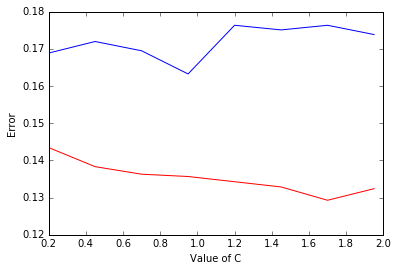

In [201]:
drawPlot(x,y, 0.2, 2.2, 0.25)

This is main function for problem 1c. Here I train on whole training set and test on testing set. Using C=1, I obtained error rate of 15.2%

In [262]:
def testLin(x, y, C=1.0):
    x_test_data, y_test_data = load_svmlight_file("a1a.t")
    y_test = y_test_data[:1000] 
    x_test = x_test_data.todense()[:1000, :119]
    sv_x, sv_y, a, b = solve_lin(x, y, C)
    y_pred_test = lin_predict(sv_x, sv_y, x_test, a, b)
    return errorRate(y_pred_test, y_test)

In [263]:
testLin(x, y, 1.0)

0.152

# 2. Kernel Trick

Function that creates gaussian kernel. Since implementation of this function using loops is too slow, I used fast functions pdist, squareform from scipy

In [175]:
def gaus_gram(x, sigma):
    pairwise_dists = squareform(pdist(x, 'euclidean'))
    return np.exp(-pairwise_dists ** 2 / 2*sigma ** 2)

Solves dual problem using gaussian kernel. Essentially same as solve_lin

In [221]:
def solve_gauss(x, y, C, sigma):
    m, n = x.shape
    K = gaus_gram(x, sigma)
    P = cvxopt.matrix(np.multiply(K, np.outer(y,y)))
    q = cvxopt.matrix(np.ones(m) * -1)
    
    A = cvxopt.matrix(y, (1,m))
    b = cvxopt.matrix(0.0)
    
    G1 = np.diag(np.ones(m)*-1)
    G2 = np.diag(np.ones(m))
    G = cvxopt.matrix(np.vstack((G1, G2)))
    h1 = np.zeros(m)
    h2 = np.ones(m)*C
    h = cvxopt.matrix(np.hstack((h1, h2)))
    
    cvxopt.solvers.options['show_progress'] = False
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(solution['x'])
    
    # Support vectors
    sv = alpha > 1e-4
    ind = np.arange(len(alpha))[sv]
    alpha = alpha[sv]
    sv_x = x[sv]
    sv_y = y[sv]

    # Bias
    bias = 0
    for i in range(len(alpha)):
        bias += sv_y[i]
        bias -= np.sum(alpha * sv_y * K[ind[i], sv].transpose())
    bias /= len(alpha)
    
    return (sv_x, sv_y, alpha, bias) 

Same as lin_predict

In [222]:
def gauss_predict(x, y, x_predict, alpha, bias, sigma):
    m, n = x_predict.shape
    y_predict = np.zeros(m)
    for i in range(m):
        temp = x - x_predict[i]
        temp =np.exp(-np.linalg.norm(temp, axis = 1) ** 2 / 2*sigma ** 2)
        y_predict[i] = np.sum(alpha * y * temp)
    return np.sign(y_predict + bias)

This is main function of problem 2. I split initail set into 5 equal pieces and cho0se one of them as validation set. I repeat this process for every subset. In each iteration I train data and then predict it on validation set. It returns error rates for training and validation. It is worth notocing that this function is fast due to use of matrix operations in sub-functions.

In [218]:
def tryGauss(x, y, C=2, sigma=1):
    m, n = x.shape #m - number of samples; n - number of features
    sz = m/5
    inds = np.random.permutation(m)
    valPairs = [(inds[i*sz:(i+1)*sz], np.concatenate((inds[:i*sz], inds[(i+1)*sz:]))) for i in range(5)]
    errV= 0
    errT = 0
    for i in range(5):
        val = valPairs[i][0]
        trn = valPairs[i][1]
        x_trn = x[trn]
        y_trn = y[trn]
        x_val = x[val]
        y_val = y[val]
        sv_x, sv_y, a, b = solve_gauss(x_trn, y_trn, C, sigma)
        y_predV = gauss_predict(sv_x, sv_y, x_val, a, b, sigma)
        y_predT = gauss_predict(sv_x, sv_y, x_trn, a, b, sigma)
        errV += errorRate(y_predV, y_val)
        errT += errorRate(y_predT, y_trn)
    return (errT/5, errV/5)

In [238]:
def drawPlotGauss_C(x, y, C_init=0.2, C_final=2.2, step = 0.5, sigma = 0.7):
    c = np.arange(C_init, C_final, step)
    ErrT = []
    ErrV = []
    for var in c:
        errT, errV = tryGauss(x, y, var, sigma)
        ErrT.append(errT)
        ErrV.append(errV)
    plt.plot(c, ErrT, 'r', c, ErrV, 'b')
    plt.ylabel("Error")
    plt.xlabel("Value of C")
    plt.show()

In [239]:
def drawPlotGauss_sigma(x, y, sigma_init=0.2, sigma_final=2.2, step = 0.5, C = 1.2):
    c = np.arange(sigma_init, sigma_final, step)
    ErrT = []
    ErrV = []
    for var in c:
        errT, errV = tryGauss(x, y, C, var)
        ErrT.append(errT)
        ErrV.append(errV)
    plt.plot(c, ErrT, 'r', c, ErrV, 'b')
    plt.ylabel("Error")
    plt.xlabel("Value of sigma")
    plt.show()

Here I plot graph Error vs Value of sigma. Here C is constant and equal to 1.2. We can observe that as sigma increases, validation also increases. On the other hand, training error decreses.

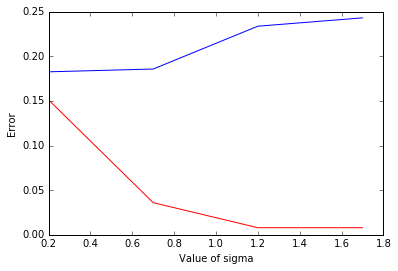

In [241]:
drawPlotGauss_sigma(x,y, 0.2, 2.2, 0.5, 1.2)

Here I plot graph Error vs Value of C. Here sigma is constant and equal to 0.7. We can observe that as C increases, validation also increases. On the other hand, training error decreses. This makes sense because as we increase C, we start to tune to noise.

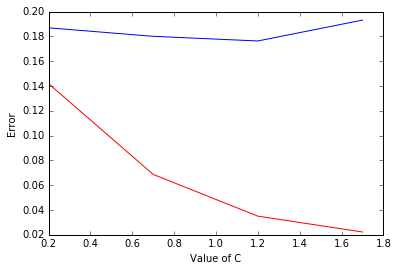

In [240]:
drawPlotGauss_C(x,y, 0.2, 2.2, 0.5, 0.7)

Here we test our SVM with Gaussian Kernel on testing set. We obtain error rate of 16%

In [266]:
def testGauss(x, y, C=1.0, sigma=0.7):
    x_test_data, y_test_data = load_svmlight_file("a1a.t")
    y_test = y_test_data[:1000] 
    x_test = x_test_data.todense()[:1000, :119]
    sv_x, sv_y, a, b = solve_gauss(x, y, C, sigma)
    y_pred_test = gauss_predict(sv_x, sv_y, x_test, a, b, sigma)
    return errorRate(y_pred_test, y_test)

In [267]:
testGauss(x, y, 1.0, 0.7)

0.16

# 3. Gaussian Mixture Models

This function generates data from GMM. Here prior is probability of a cluster in a given data. n is number of samples required to generate. 

In [183]:
def genData(n, prior, mu, sigma):
    k = prior.shape[0]
    samples = np.concatenate([np.random.multivariate_normal(mu[i], sigma[i], int(prior[i]*n)) 
                             for i in range(k)])
    return samples

This function takes data, weights(w), means and colors and scatters the points and means, coloring them in colors of their cluster. I use this function during EM

In [242]:
def hardPlot(data, w, mean1, mean2, colors):
    hard = np.argmax(w, axis=0)
    col = [colors[i] for i in hard]
    plt.scatter(data[:,0], data[:,1], c=col)
    plt.scatter([mean1[0], mean2[0]], [mean1[1], mean2[0]], c=["green", "yellow"], s = 100)
    plt.show()

This is my implementation of EM. I tried to use matrix operations as much as possible. Because of this, this function is very fast compared to my previuos loop-version. 
Here prior is "pi" from lecture slides. mu is mean vector.
In this function I use stopping condition: if difference in objective functions is smaller that 0.001 it stops. Every ten iterations it makes plots on new cluster centroids and hard membership assignments according responsibilities in lecture slides. I spent an extremely huge amount of time on this function.

In [305]:
def gaussEM(data, prior, mu, sigma, tolerance=0.001, max_iter=1000, plot=False):
    m, n = data.shape
    k = len(prior)
    colors = np.random.rand(k+2)
    objective_old = 0
    for i in range(max_iter):
        objective_new = 0
        # E-step
        w = np.zeros((k,m))
        for j in range(k):
            w[j] = prior[j] * mvn(mu[j], sigma[j]).pdf(data)
        w /= np.sum(w, axis=0)
        
        # M-step
        prior = np.sum(w, axis=1)/m
        mu = np.dot(w, data)/np.sum(w, axis=1)
        
        sigma = np.zeros((k, n, n))
        for j in range(k):
            temp1 = data - mu[j]
            temp2 = mm(temp1[:,:,None], temp1[:, None, :])
            sigma[j] = np.sum(w[j, :, None, None] * temp2, axis=0)
        sigma /= np.sum(w, axis=1)[:, None, None]
        
        if plot and i%20 == 0:
            hardPlot(data, w, mu[0], mu[1], colors)
        
        for prior_i, mu_i, sigma_i in zip(prior, mu, sigma):
            objective_new += prior_i * mvn(mu_i, sigma_i).pdf(data)
        objective_new = np.sum(np.log(objective_new))
        
        if np.abs(objective_new - objective_old) < tolerance:
            break
        objective_old = objective_new
        if plot:
            hardPlot(data, w, mu[0], mu[1], colors)
        hard = np.argmax(w, axis=0)
    return objective_new, prior, mu, sigma, hard            

Here I generate data

In [320]:
mu = np.array([[0,5], [-2,1]])
sigma = np.array([[[3, 0], [0, 0.5]], [[1,0],[0,2]]])
prior = np.array([0.3, 0.7])
xs = genData(1000, prior, mu, sigma)


And here I run my EM function on previously generated data. We can see that in the end it divides the set very nicely. However it really depends on initial means and sigmas. 

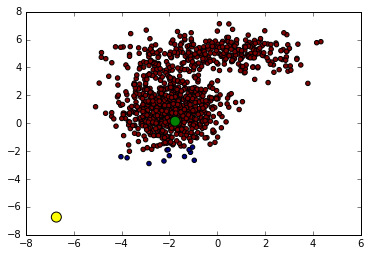

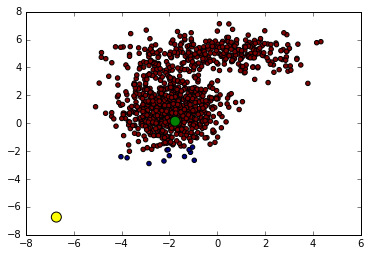

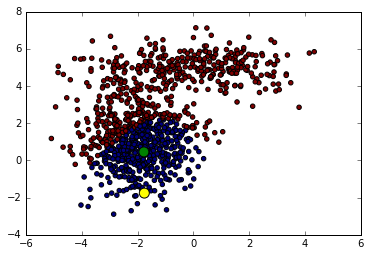

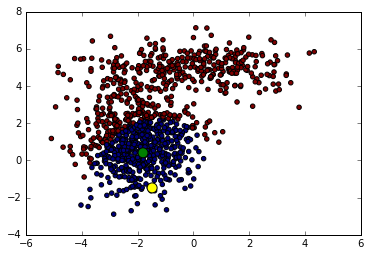

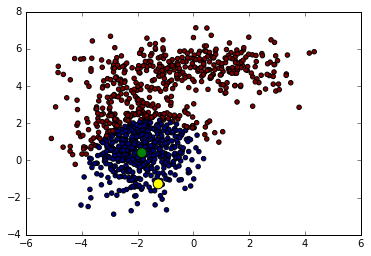

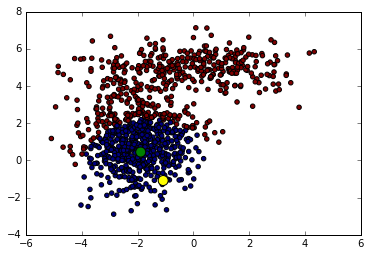

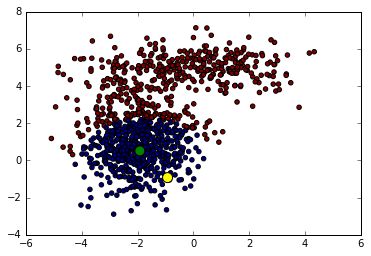

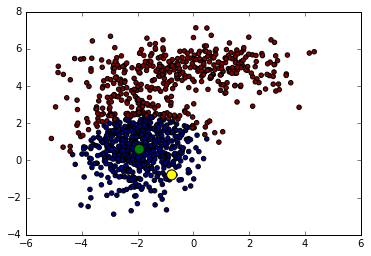

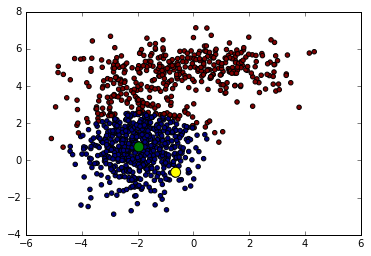

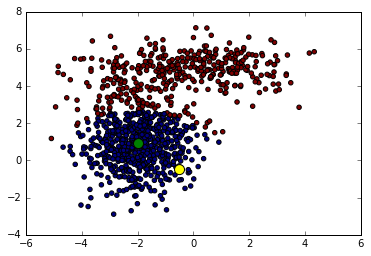

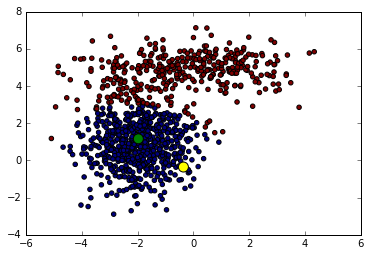

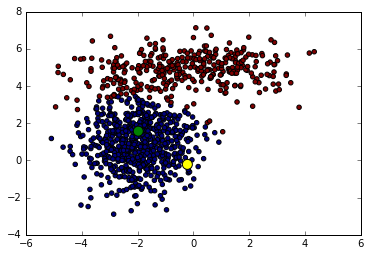

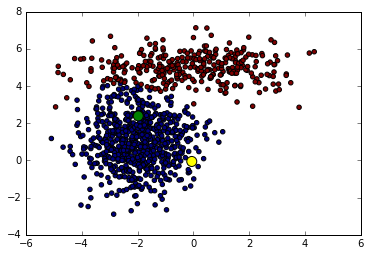

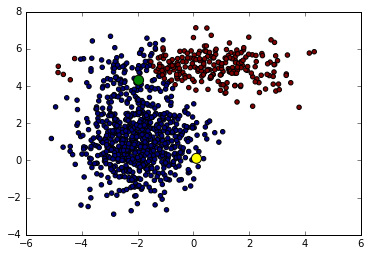

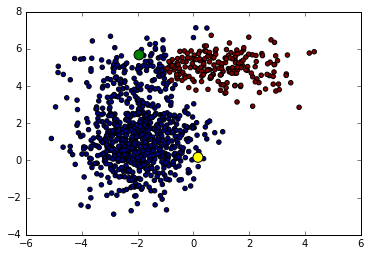

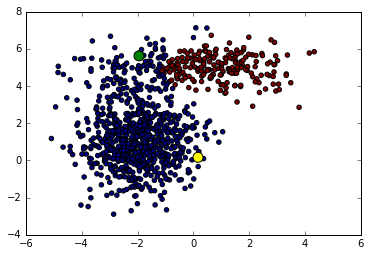

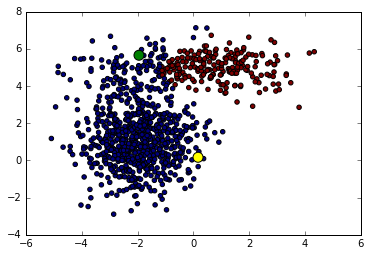

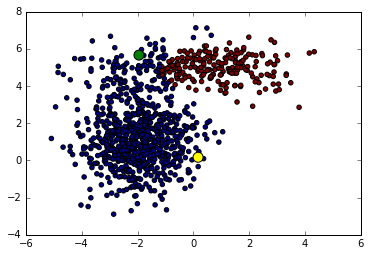

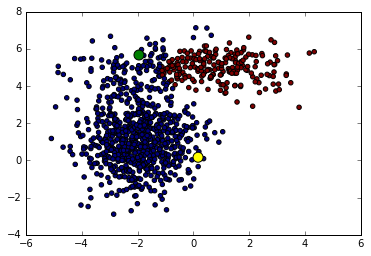

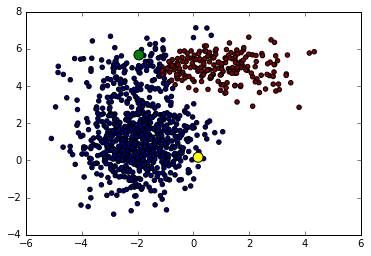

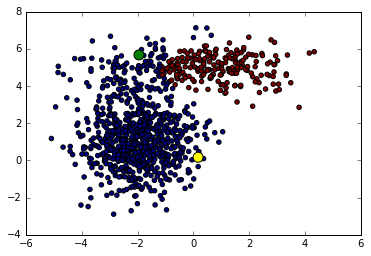

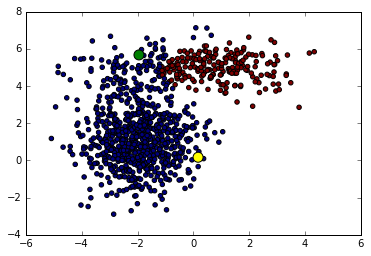

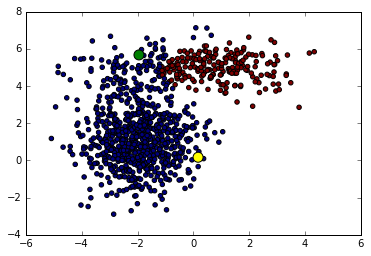

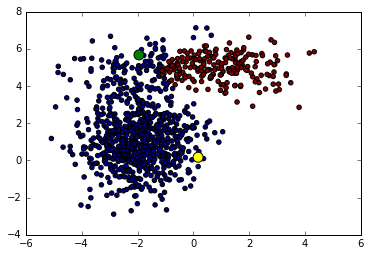

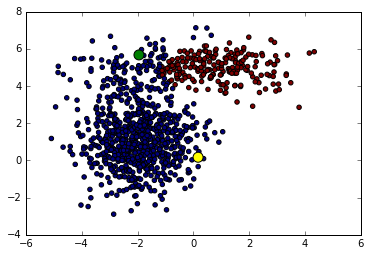

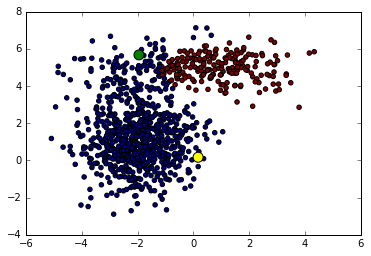

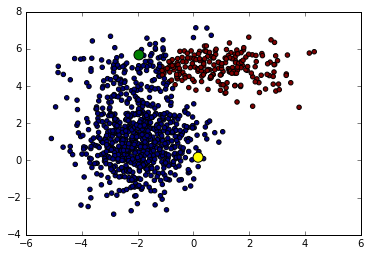

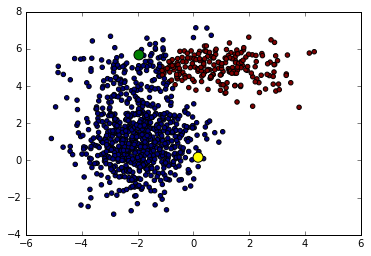

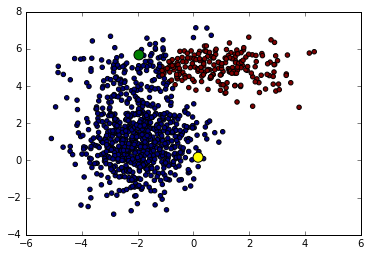

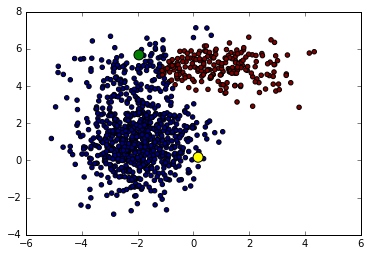

In [322]:
pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)
xs.shape
ll1, pis1, mus1, sigmas1, hard1 = gaussEM(xs, pis, mus, sigmas, plot=True)

Error rate is 10.4% which is not so bad. Means are not really close to true means

In [324]:
true_k = np.concatenate((np.zeros(int(0.3*1000)), np.ones(int(0.7*1000))))
print mus1
temp = np.abs(true_k-hard1).sum()
err_gmm = min(temp, 1000 - temp)
print err_gmm

[[-1.94930912  5.67133795]
 [ 0.16967834  4.94990341]]
104.0


## 3d

Here are two examples when GMM beats Kmeans. Second one is from lecture slides. It prints true parameters of Gaussian mixture. And from plots we can see initial means. In the first one error rate of GMM is 33.6% compared to 49.8 for K-means. In second error rate of GMM is 23% compared to 47% of K means. We can see that K_means works really bad when true means are close even though they have very different covariance matrices.

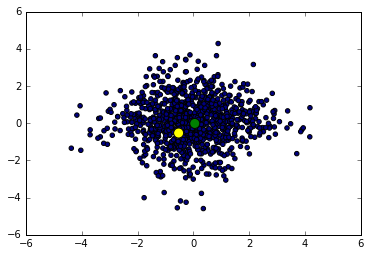

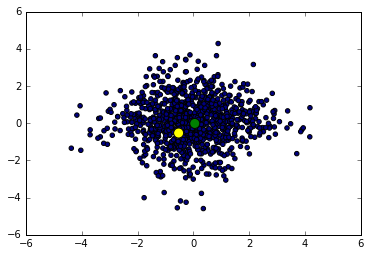

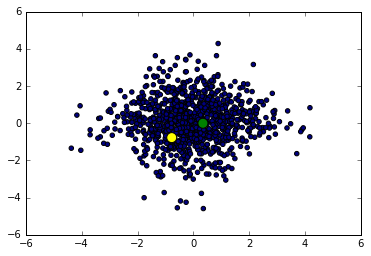

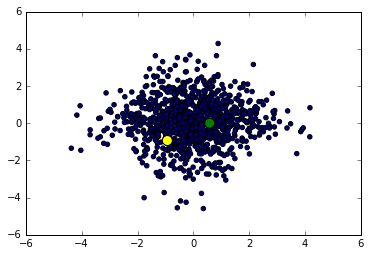

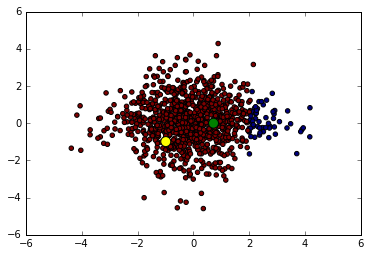

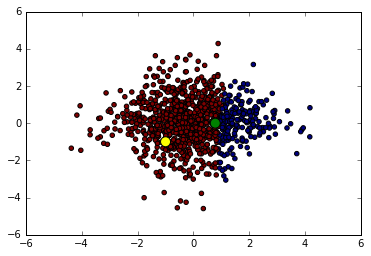

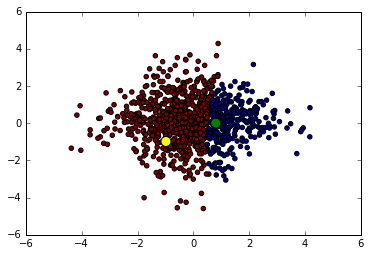

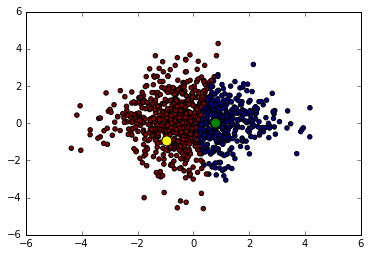

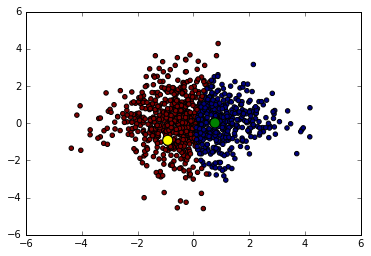

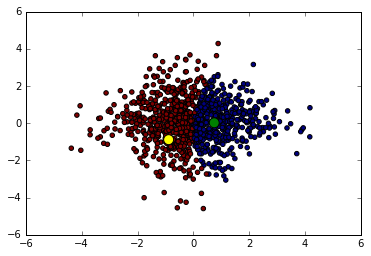

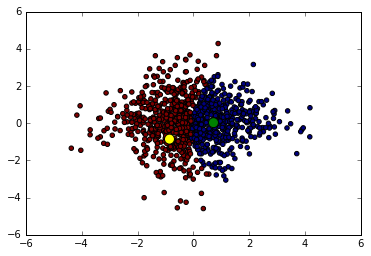

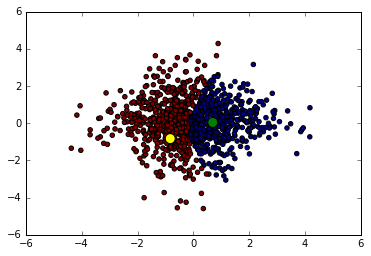

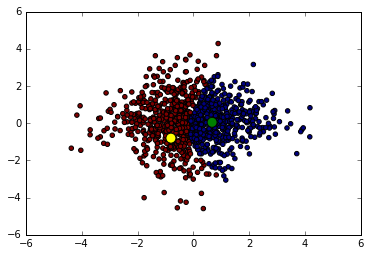

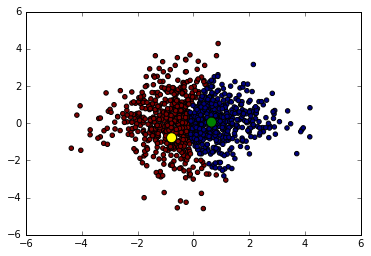

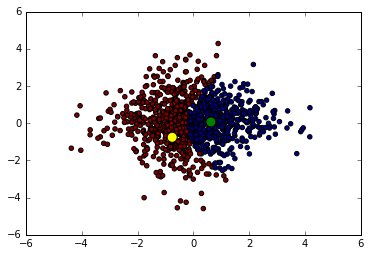

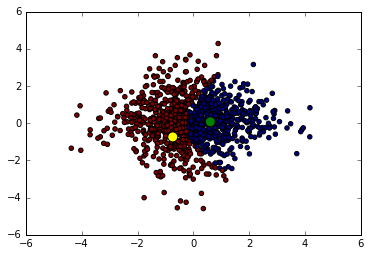

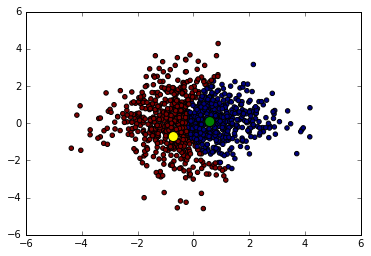

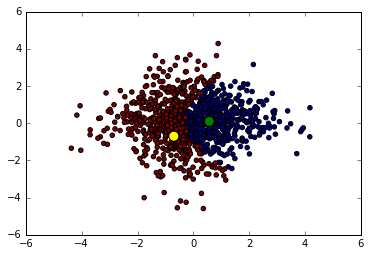

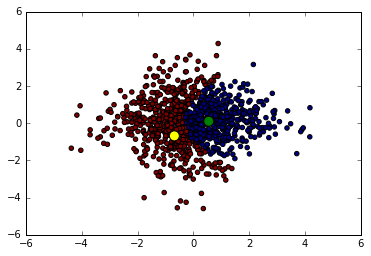

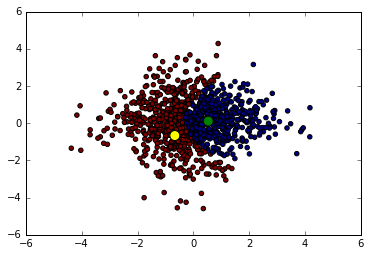

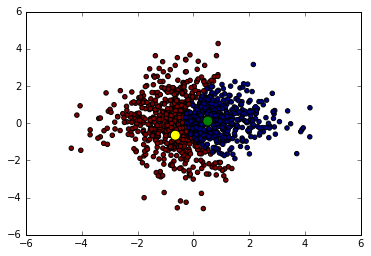

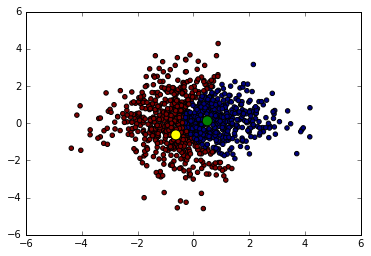

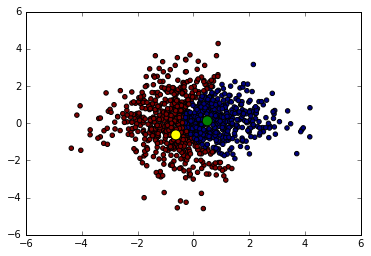

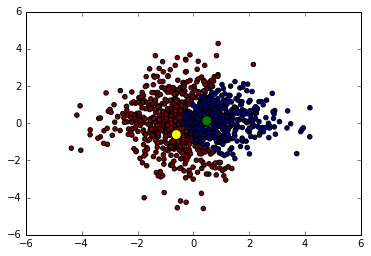

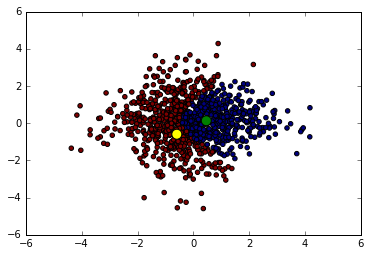

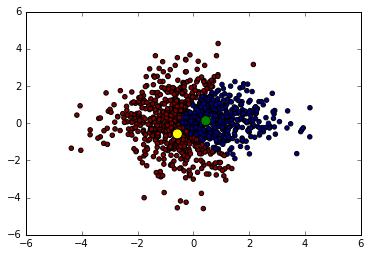

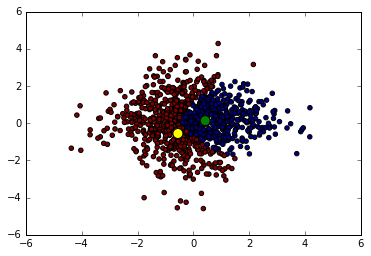

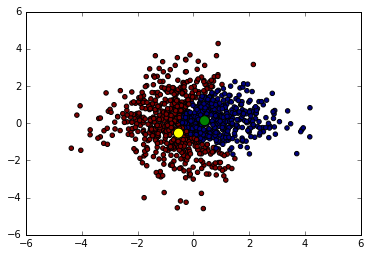

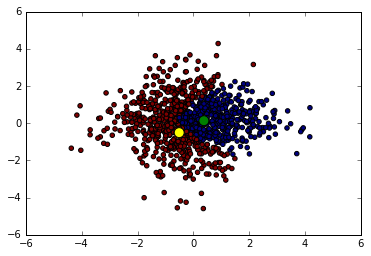

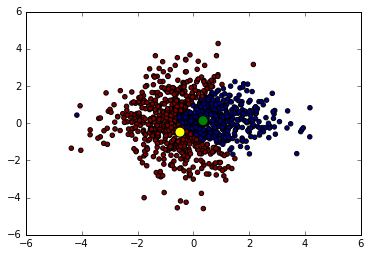

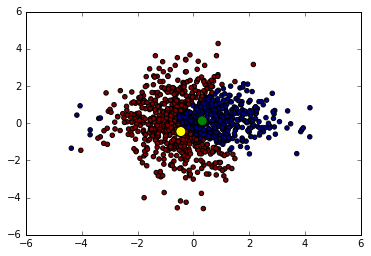

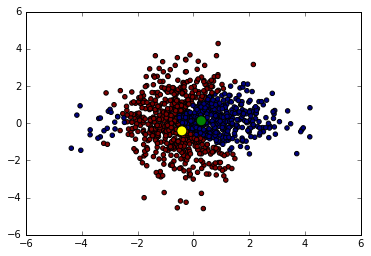

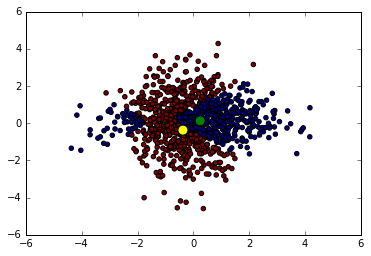

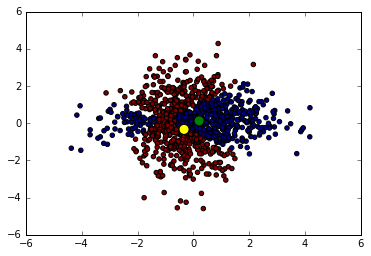

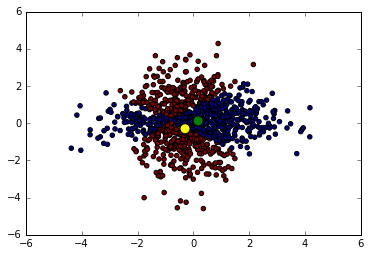

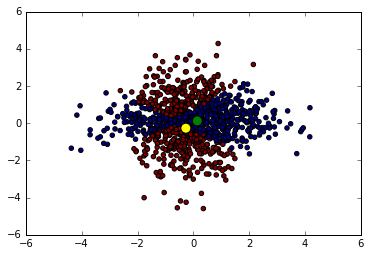

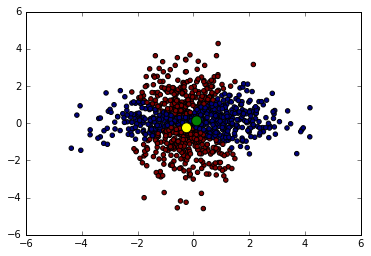

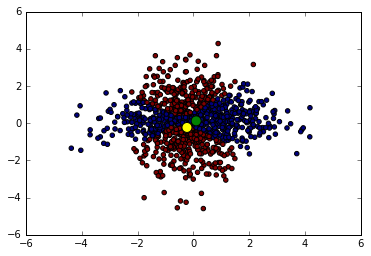

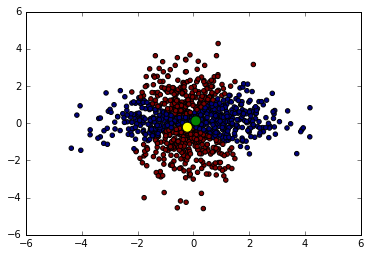

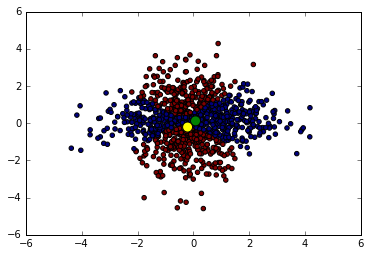

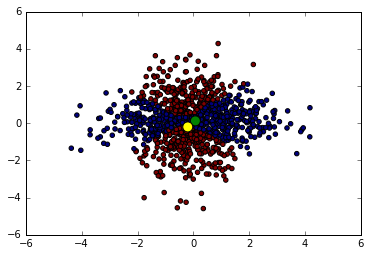

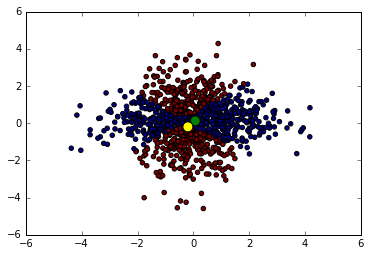

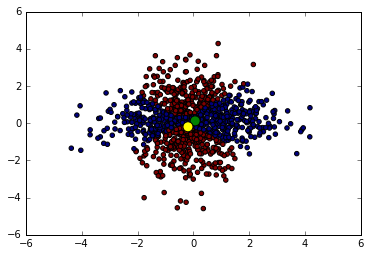

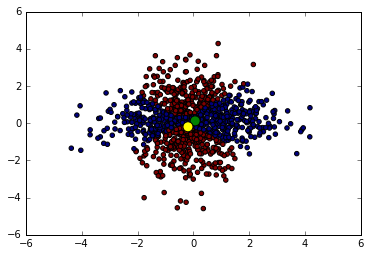

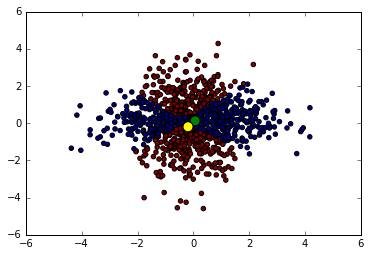

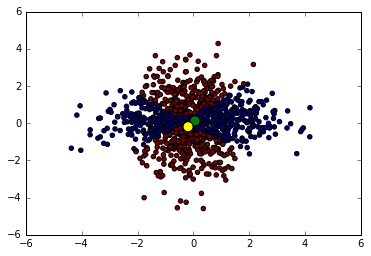

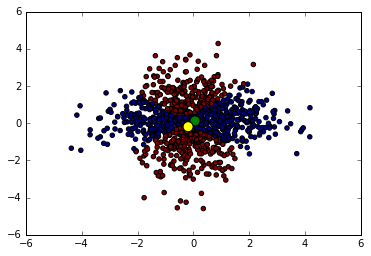

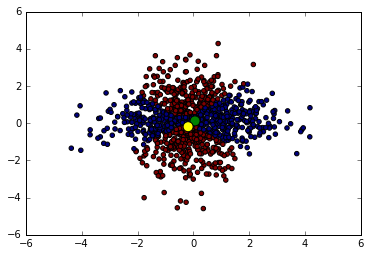

336.0
498.0
[[0 0]
 [0 0]]
[[ 0.05926285  0.12283603]
 [-0.18788745  0.02195047]]
[[[ 3.   0. ]
  [ 0.   0.5]]

 [[ 1.   0. ]
  [ 0.   2. ]]]
[[[ 2.48382419  0.04790198]
  [ 0.04790198  0.65464288]]

 [[ 0.81927219 -0.02892376]
  [-0.02892376  2.36590937]]]


In [319]:
mu = np.array([[0,0], [0,0]])
sigma = np.array([[[3, 0], [0, 0.5]], [[1,0],[0,2]]])
prior = np.array([0.3, 0.7])
true_k = np.concatenate((np.zeros(int(0.3*1000)), np.ones(int(0.7*1000))))

xs = genData(1000, prior, mu, sigma)
pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)
xs.shape
ll1, pis1, mus1, sigmas1, hard1 = gaussEM(xs, pis, mus, sigmas, plot=True)
temp = np.abs(true_k-hard1).sum()
err_gmm = min(temp, 1000 - temp)
print err_gmm

kmeans = KMeans(n_clusters=2).fit(xs)
temp = np.abs(true_k-kmeans.labels_).sum()
min(temp, 1000 - temp)
err_kmeans = min(temp, 1000 - temp)
print err_kmeans
if (err_gmm < err_kmeans):
    print mu
    print mus1
    print sigma
    print sigmas1

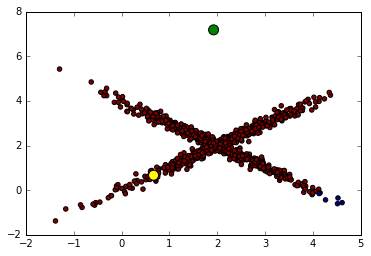

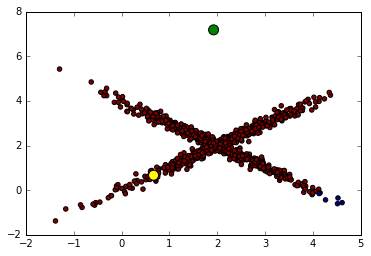

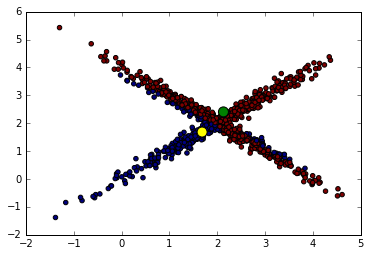

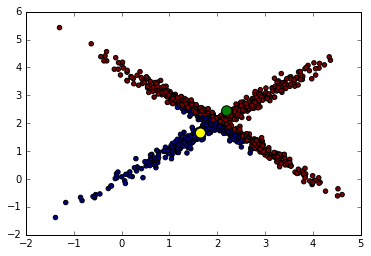

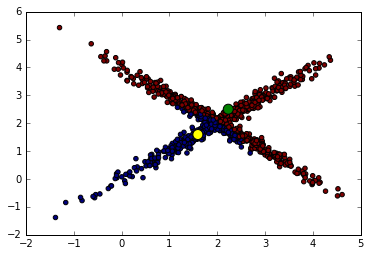

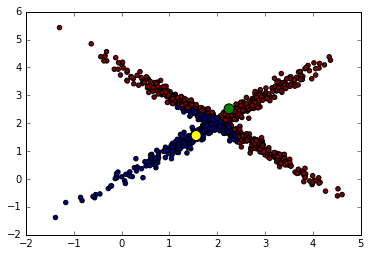

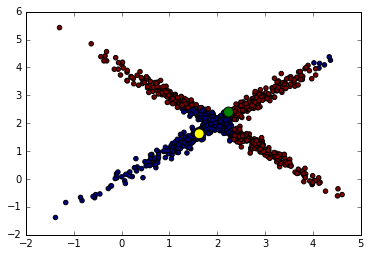

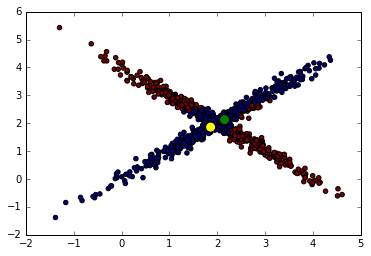

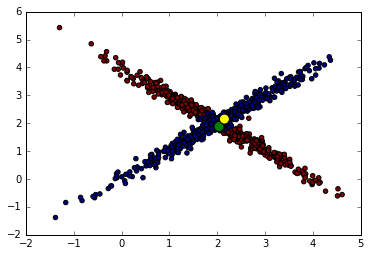

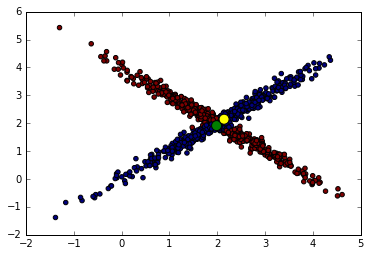

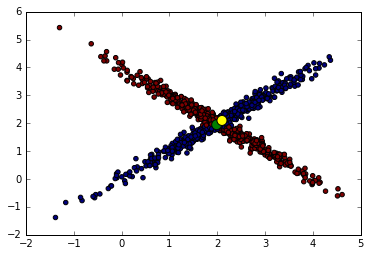

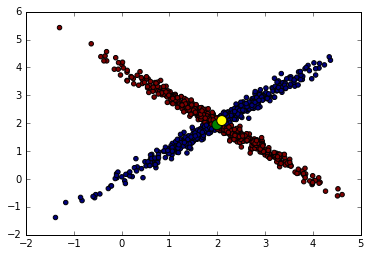

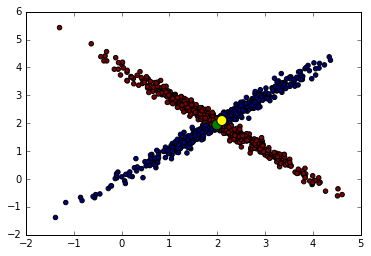

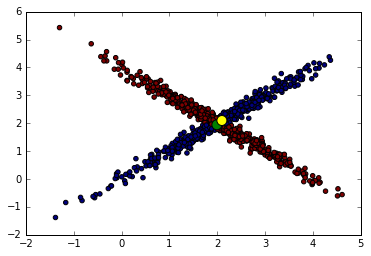

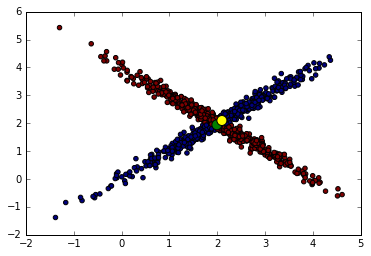

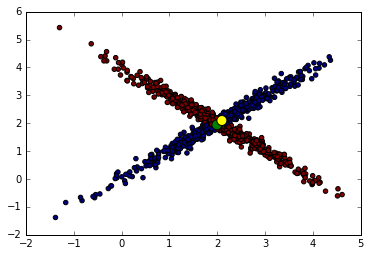

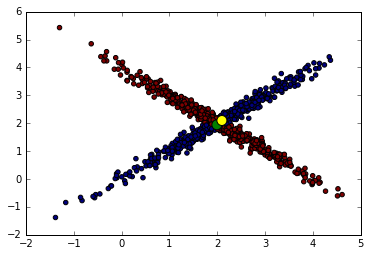

230.0
476.0
[[2 2]
 [2 2]]
[[ 1.99189856  1.94380595]
 [ 2.09674179  2.03208603]]
[[[ 1.    0.99]
  [ 0.99  1.  ]]

 [[ 1.   -0.99]
  [-0.99  1.  ]]]
[[[ 0.98903796 -0.97482987]
  [-0.97482987  0.98403801]]

 [[ 0.98940474  0.96813644]
  [ 0.96813644  0.97204862]]]


In [314]:
mu = np.array([[2,2], [2,2]])
sigma = np.array([[[1, 0.99], [0.99, 1]], [[1,-0.99],[-0.99,1]]])
prior = np.array([0.5, 0.5])
true_k = np.concatenate((np.zeros(int(0.3*1000)), np.ones(int(0.7*1000))))

xs = genData(1000, prior, mu, sigma)
pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)
xs.shape
ll1, pis1, mus1, sigmas1, hard1 = gaussEM(xs, pis, mus, sigmas, tolerance=0.01, max_iter=100, plot=True)
temp = np.abs(true_k-hard1).sum()
err_gmm = min(temp, 1000 - temp)
print err_gmm

kmeans = KMeans(n_clusters=2).fit(xs)
temp = np.abs(true_k-kmeans.labels_).sum()
min(temp, 1000 - temp)
err_kmeans = min(temp, 1000 - temp)
print err_kmeans
if (err_gmm < err_kmeans):
    print mu
    print mus1
    print sigma
    print sigmas1

Overall, homework 2 was hard but very interesting